In [1]:
import pandas as pd
target = pd.read_csv('data/training_set_labels.csv')
data = pd.read_csv('data/training_set_features.csv')
data = data.merge(target, on="respondent_id").drop(columns=['respondent_id', 'seasonal_vaccine'])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [3]:
def grab_numeric(df):
    return df.select_dtypes(['float64', 'int64'])

GrabNumeric = FunctionTransformer(grab_numeric)

In [4]:
num_features = list(range(0, 17)) + [27, 28]
cat_features = list(range(17, 27)) + [29, 30]

In [5]:
numeric_transformer = Pipeline(
    steps=[('grab_num', GrabNumeric), 
           ('num_impute', SimpleImputer(strategy='median', add_indicator=True)), 
           ('scaler', StandardScaler())])

categorical_transformer = Pipeline(
    steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
           ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)], remainder='passthrough')

In [6]:
models = {'Baseline':
              {'regressor': LogisticRegression(random_state=20220124, max_iter=1000),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran' : None
              },
          'DecisionTree':
              {'regressor': DecisionTreeClassifier(random_state=20211122),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },
          'RandomForest':
              {'regressor': RandomForestClassifier(random_state=10151997),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },
          'GradientBoost':
              {'regressor': GradientBoostingClassifier(random_state=20220125),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              }
         }

In [7]:
def data_split(data, target):
    X = data.drop(columns=target)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10151997)
    return X_train, X_test, y_train, y_test

In [8]:
def run_models(models, data, target):
    """
    Takes in dict of models to run, df of dataset, string name of target
    Prints every model in dict, its accuracy, precision, auc scores, and time it took to ran 
    """
    X_train, X_test, y_train, y_test = data_split(data, target)
    for name, model in models.items():
        print(name, 'Model:')
        X_train_processed = model['preprocessor'].fit_transform(X_train)
        X_test_processed = model['preprocessor'].transform(X_test)
        model['fit_regressor'] = model['regressor'].fit(X_train_processed, y_train)
        model['output'] = [model['fit_regressor'].score(X_test_processed, y_test), 
                           precision_score(y_test, model['regressor'].predict(X_test_processed)), 
                           roc_auc_score(y_test, model['regressor'].predict_proba(X_test_processed)[:,1])]
        model['time_ran'] = time.asctime()
        print(model, '\n')

In [9]:
# run_models(models, data, 'h1n1_vaccine')

In [10]:
def run_gridsearch(models, params, data, target):
    X_train, X_test, y_train, y_test = data_split(data, target)
    for model in models:
        if model in params.keys():
            print(model, 'Grid Search:')
            pipe = Pipeline(steps=[('col_transformer', models[model]['preprocessor']), 
                             ('regressor', models[model]['regressor'])])
            grid = params[model]
            gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='precision', cv=5)
            gridsearch.fit(X_train, y_train)
            print(f'Cross validation mean: {gridsearch.cv_results_["mean_test_score"]}')
            print(f'Test precision: {gridsearch.best_score_ :.2%}')
            print(f'Optimal prameters: {gridsearch.best_params_}')

In [11]:
test_params = {'DecisionTree': [{'regressor__max_depth': [None, 2, 6, 10], 
         'regressor__min_samples_split': [5, 10]}]}

In [12]:
# run_gridsearch(models, test_params, data, 'h1n1_vaccine')

***

In [13]:
# features = data.drop(columns='h1n1_vaccine').columns.to_list()
# outcome = 'h1n1_vaccine'

In [14]:
# # Plot setting
# sns.set_context("paper")
# sns.set(font='serif')
# sns.set_style("white", {
#     "font.family": "serif",
#     "font.serif": ["Times", "Palatino", "serif"]
# })

In [15]:
# total = data[features].isnull().sum().sort_values(ascending = False)
# percent = (data[features].isnull().sum()/data[features].isnull().count()*100).sort_values(ascending = False)
# missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_train_data

In [16]:
# for feature in features : 
#     df = data.groupby([feature,outcome])[outcome].count().unstack(outcome)
#     df.plot(kind='bar', figsize=(10,5))
#     plt.title(feature)
#     plt.show()

***

In [26]:
df = data.drop(columns='h1n1_vaccine').fillna('Unknown')

In [27]:
df = pd.get_dummies(df, drop_first=True)

In [28]:
y = data['h1n1_vaccine']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.25, random_state=10151997)

In [32]:
my_model = RandomForestClassifier(n_estimators=100, random_state=0)
my_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [34]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=10151997)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0316 ± 0.0037,doctor_recc_h1n1_1.0
0.0158 ± 0.0035,health_insurance_1.0
0.0093 ± 0.0004,opinion_h1n1_vacc_effective_5.0
0.0086 ± 0.0033,opinion_h1n1_risk_4.0
0.0078 ± 0.0013,health_insurance_Unknown
0.0073 ± 0.0013,opinion_h1n1_risk_5.0
0.0033 ± 0.0036,doctor_recc_seasonal_1.0
0.0031 ± 0.0012,h1n1_knowledge_2.0
0.0030 ± 0.0017,opinion_seas_risk_4.0
0.0025 ± 0.0014,opinion_seas_vacc_effective_5.0


In [ ]:
df_fi = pd.DataFrame(dict(feature_names=X.columns.tolist(),
                          feat_imp=perm.feature_importances_, 
                          std=perm.feature_importances_std_,
                          ))
df_fi = df_fi.round(4)
df_fi.sort_values('feat_imp', ascending=False)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# create df with columns = each feature, rows = score for each permutation each cv (600 in your case)
df_results = pd.DataFrame(data=perm.results_[:10], columns=X.columns)
# feat_imps values will be same as perm.feature_importances_, but as a pd.Series with index labels corresponding to the feature names
feat_imps = df_results.mean().sort_values(ascending=False)
# reorder columns from most to least important
df_results = df_results[feat_imps.index]
# create boxplots of full results. pd.melt() is a handy way to reformat into a longform dataframe that plays well with plotly express.
fig = px.box(df_results.melt(), x='variable', y='value', orientation='v')
# add a marker showing the mean feature importance for each
fig.add_trace(go.Scatter(x=feat_imps.index, y=feat_imps.values, mode='markers', marker=dict(color='red'), name = 'Mean'))
fig

***

In [35]:
X_pdp = data.drop(columns='h1n1_vaccine').fillna('Unknown')
X_pdp = pd.get_dummies(X_pdp, drop_first=True)
y_pdp = data['h1n1_vaccine']
X_train, X_test, y_train, y_test = train_test_split(X_pdp, y_pdp, test_size=.25, random_state=10151997)

In [36]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=0)

In [39]:
feature_names = [col for col in X_pdp.columns]

In [41]:
# from sklearn import tree
# import graphviz

# tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
# graphviz.Source(tree_graph)

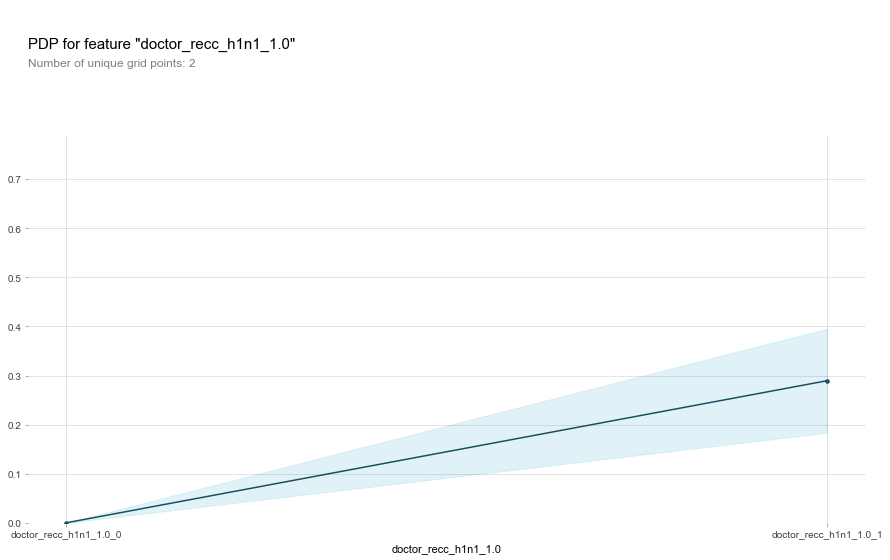

In [44]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=feature_names, feature='doctor_recc_h1n1_1.0')

# plot it
pdp.pdp_plot(pdp_goals, 'doctor_recc_h1n1_1.0')
plt.show()

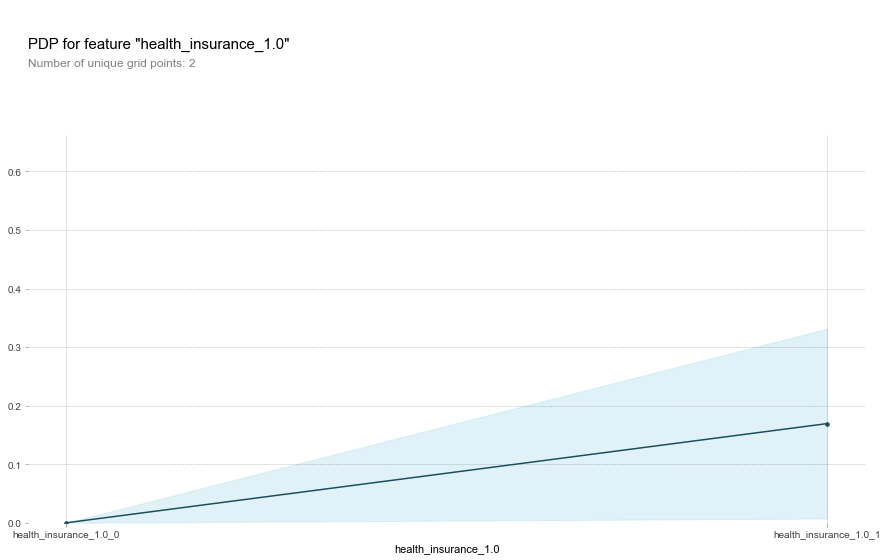

In [45]:
feature_to_plot = 'health_insurance_1.0'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

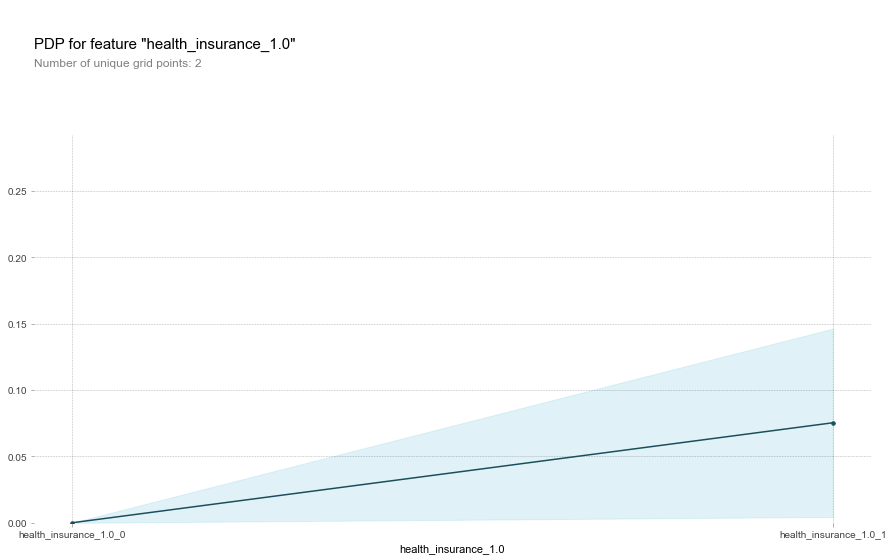

In [48]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=1015).fit(X_train, y_train)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

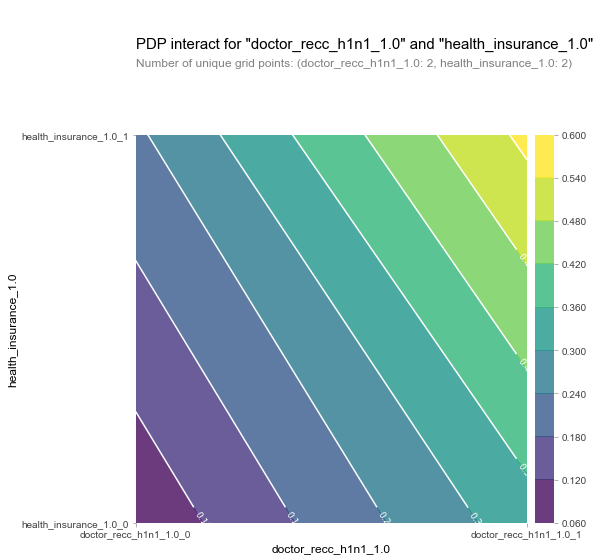

In [50]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['doctor_recc_h1n1_1.0', 'health_insurance_1.0']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

In [52]:
from sklearn.svm import SVC
svc = SVC().fit(X_train, y_train)
perm = PermutationImportance(svc).fit(X_test, y_test)
eli5.show_weights(perm)

In [ ]:
from sklearn.feature_selection import SelectFromModel

# ... load data

perm = PermutationImportance(SVC(), cv=5)
perm.fit(X, y)

# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least 0.05:
sel = SelectFromModel(perm, threshold=0.05, prefit=True)
X_trans = sel.transform(X)

# It is possible to combine SelectFromModel and
# PermutationImportance directly, without fitting
# PermutationImportance first:
sel = SelectFromModel(
    PermutationImportance(SVC(), cv=5),
    threshold=0.05,
).fit(X, y)
X_trans = sel.transform(X)